In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from scipy import sparse

# Generate some indices
Even the sparse matrices won't fit in memory. So we will have to loop through them when making predictions or sampling random items.

In [10]:
#count number of items:
indptr = [0]

for chunkID in range(12):
    scores = np.load(f'../processed_data/D4_all{chunkID}.npy')
    indptr.append(indptr[-1] + scores.shape[0])


In [11]:
scores = np.concatenate([np.load(f'../processed_data/D4_all{i}.npy') for i in range(12)])

In [12]:
np.percentile(scores, 0.05)

-58.91

# functions to handle the slabs

In [13]:
def extractFPs(chunkID, indptr, isTrain):
    fp = sparse.load_npz(f'../processed_data/D4_all{chunkID}.npz')
    mask = isTrain[indptr[chunkID]:indptr[chunkID+1]]
    return fp[mask]

def buildTrain(indptr, isTrain, verbose=0):
    if verbose:
        print('building training matrix')
    fps = sparse.vstack([extractFPs(i, indptr, isTrain) for i in range(12)])
    return fps

def chunkPredictProba(model, indptr, isTrain, verbose=0):
    if verbose:
        print('predicting probabilities')
    probas = []
    for chunkID in range(12):
        fps = extractFPs(chunkID, indptr, ~isTrain)
        proba = model.predict_proba(fps)[:,1]
        probas.append(proba)
    return np.concatenate(probas)

# Train and RF regressor and Logistic Regression models

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=10000, C=0.1)

# How long to find the 50k - 500k top 0.4%?

In [15]:
trainingSetSizes = [5000, 10_000] + [10000*2<<i for i in range(0,8)]
desiredNumLigands = [25_000, 50_000, 100_000, 200_000, 300_000]

In [16]:
trainingSetSizes[-2:]

[1280000, 2560000]

In [17]:
np.percentile(scores, 0.4)

-53.97

In [18]:
test_cutoff = np.percentile(scores, 0.4)

topK = scores<test_cutoff

#df = pd.DataFrame(columns=['Algorithm', 'Training size', 'N ligands explored', '% top-k found'])
df = pd.DataFrame(columns=['Algorithm', 'Training size', 'N hits wanted', 'N hits explored'])
count=0

for i in range(3):
    for numWanted in desiredNumLigands:
        idx = np.arange(scores.shape[0])
        np.random.shuffle(idx)

        for size in trainingSetSizes:
            #split indices into train and test:
            train = idx[:size].copy()
            test = idx[size:].copy()
            train.sort()
            test.sort()
    
            #generate a 'is a training instance' mask. 
            isTrain = np.zeros(scores.shape[0]).astype(bool)
            isTrain[train]=True
    
            #topK molecules already found in the training set:
            numFound = topK[train].sum()
            numRequired = numWanted - numFound
            
            #fit model:
            cutoff = np.percentile(scores[isTrain],0.8)
            model.fit(buildTrain(indptr, isTrain, 1), scores[isTrain]<cutoff)

            #predict (slowest step):
            proba = chunkPredictProba(model, indptr, isTrain, 1)
        
            #rank the probabilities
            proba_sorted = (-proba).argsort()
            
            #sorted the unseen instances by probability (highest prob first):
            test = test[proba_sorted]

            #topK molecules already found in the training set:
            numSampled = np.argmax(np.cumsum(topK[test])>numRequired)
            
            df.loc[count] = ['morgan_feat', size, numWanted, numSampled+size]
            count+=1
            print(count, size, numWanted, numSampled+size)
                
                
            df.to_csv('../processed_data/D4_single_'+str(0.4)+'.csv')

building training matrix
predicting probabilities
1 5000 25000 704948
building training matrix
predicting probabilities
2 10000 25000 656318
building training matrix
predicting probabilities
3 20000 25000 293579
building training matrix
predicting probabilities
4 40000 25000 281199
building training matrix
predicting probabilities
5 80000 25000 270148
building training matrix
predicting probabilities
6 160000 25000 300213
building training matrix
predicting probabilities
7 320000 25000 441575
building training matrix
predicting probabilities
8 640000 25000 736169
building training matrix
predicting probabilities
9 1280000 25000 1354155
building training matrix
predicting probabilities
10 2560000 25000 2609531
building training matrix
predicting probabilities
11 5000 50000 1174373
building training matrix
predicting probabilities
12 10000 50000 920108
building training matrix
predicting probabilities
13 20000 50000 727603
building training matrix
predicting probabilities
14 40000 50000 

building training matrix
predicting probabilities
112 10000 50000 859894
building training matrix
predicting probabilities
113 20000 50000 883579
building training matrix
predicting probabilities
114 40000 50000 651334
building training matrix
predicting probabilities
115 80000 50000 548573
building training matrix
predicting probabilities
116 160000 50000 543827
building training matrix
predicting probabilities
117 320000 50000 638897
building training matrix
predicting probabilities
118 640000 50000 897030
building training matrix
predicting probabilities
119 1280000 50000 1492386
building training matrix
predicting probabilities
120 2560000 50000 2725105
building training matrix
predicting probabilities
121 5000 100000 2338464
building training matrix
predicting probabilities
122 10000 100000 2146111
building training matrix
predicting probabilities
123 20000 100000 1869619
building training matrix
predicting probabilities
124 40000 100000 1500385
building training matrix
predicting

In [20]:
percentiles = np.argsort(np.argsort(scores)) * 100. / (scores.shape[0] - 1)


In [28]:
docking_scores = np.array(df['Energy'].str.strip('¶')).astype(float)

In [35]:
percentiles = np.concatenate([scores, docking_scores]).argsort().argsort()*100 / (scores.shape[0]+docking_scores.shape[0] - 1)




In [43]:
ranks = np.concatenate([scores, docking_scores]).argsort().argsort()

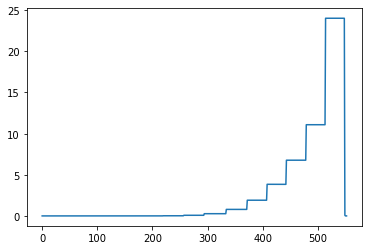

In [39]:
plt.plot(percentiles[-docking_scores.shape[0]:])

In [37]:
3.17815987e+01

31.7815987

In [26]:
df = pd.read_csv('https://gist.githubusercontent.com/ljmartin/82f0dfe9f58e584a3e5186afe6e75973/raw/4315cb08931628f03781546da46c0b98875c453b/41586_2019_917_MOESM4_ESM.csv')
df.head()

,ZINC ID,Global Rank∗,Clustered Rank†,Energy,TC to knowns‡,Cosest neighbor among known DRD4 binders,Top-pick or not,Just from energy window,Energy window,Tested or not,Binder or not,D4 Ki(nM),D2 Ki(nM),D3 Ki(nM),cAMP EC50(nM),Inhibition (%) at 10uM,SMILES,Vendor ID,Charge from docked poses
0,ZINC000191583186,1,1,-75.5,0.30,ZINC000028347504,0,1,-75,1,1,1390.0,3860,1730,NT||,82.48,Cc1ccc(C[C@@H](CO)N[C@@H](C)CCc2ccccc2[N+](=O)...,Z1804039468,1.0
1,ZINC000159533726,2,2,-73.67,0.33,ZINC000103232405,0,1,-75,1,0,NaN,NaN,NaN,NT,2.68,C[C@H](C(=O)Nc1cc([N+](=O)[O-])ccc1Cl)N(C)C[C@...,Z1514931360,1.0
2,ZINC000151228439,3,4,-73.47,0.34,ZINC000053274848,0,1,-75,1,0,NaN,NaN,NaN,NT,17.5,C[C@@H](NC[C@](C)(O)c1ccccc1)c1cn(-c2ccccc2)nn1,Z1419817479,1.0
3,ZINC000291023493,5,5,-72.95,0.31,ZINC000028363497,0,1,-75,1,0,NaN,NaN,NaN,NT,-10.33,C[C@H](Nc1cc(-n2cccn2)nc(N)n1)[C@H](c1ccccc1)N...,Z2179794811,2.0
4,ZINC000593577820,7,7,-72.5,0.35,ZINC000036216606,0,1,-75,1,0,NaN,NaN,NaN,NT,11.48,COC(=O)C[C@H]1CSCCN1Cc1cn(-c2cccc(C)c2)nc1C,Z2480456501,1.0


In [41]:
df['percentile'] = percentiles[-docking_scores.shape[0]:]



In [46]:
df['rank'] = ranks[-docking_scores.shape[0]:]+1

In [48]:
len(scores)

116241184

In [47]:
df

,ZINC ID,Global Rank∗,Clustered Rank†,Energy,TC to knowns‡,Cosest neighbor among known DRD4 binders,Top-pick or not,Just from energy window,Energy window,Tested or not,...,D4 Ki(nM),D2 Ki(nM),D3 Ki(nM),cAMP EC50(nM),Inhibition (%) at 10uM,SMILES,Vendor ID,Charge from docked poses,percentile,rank
0,ZINC000191583186,1,1,-75.5,0.30,ZINC000028347504,0,1,-75,1,...,1390.00,3860,1730,NT||,82.48,Cc1ccc(C[C@@H](CO)N[C@@H](C)CCc2ccccc2[N+](=O)...,Z1804039468,1.0,0.000000,1
1,ZINC000159533726,2,2,-73.67,0.33,ZINC000103232405,0,1,-75,1,...,NaN,NaN,NaN,NT,2.68,C[C@H](C(=O)Nc1cc([N+](=O)[O-])ccc1Cl)N(C)C[C@...,Z1514931360,1.0,0.000002,3
2,ZINC000151228439,3,4,-73.47,0.34,ZINC000053274848,0,1,-75,1,...,NaN,NaN,NaN,NT,17.5,C[C@@H](NC[C@](C)(O)c1ccccc1)c1cn(-c2ccccc2)nn1,Z1419817479,1.0,0.000003,5
3,ZINC000291023493,5,5,-72.95,0.31,ZINC000028363497,0,1,-75,1,...,NaN,NaN,NaN,NT,-10.33,C[C@H](Nc1cc(-n2cccn2)nc(N)n1)[C@H](c1ccccc1)N...,Z2179794811,2.0,0.000006,8
4,ZINC000593577820,7,7,-72.5,0.35,ZINC000036216606,0,1,-75,1,...,NaN,NaN,NaN,NT,11.48,COC(=O)C[C@H]1CSCCN1Cc1cn(-c2cccc(C)c2)nc1C,Z2480456501,1.0,0.000009,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,ZINC000664448457,27921026,345068,-35,0.40,ZINC000000346678,0,1,-35,1,...,NaN,NaN,NaN,NT,6.51,CC1C[C@H]2CC[C@@H](C1)N2C(=O)C(=O)c1ccc(F)cc1,Z2615266005,0.0,24.022647,27924343
549,ZINC000621433144,96169,611,-57.82¶,0.33,ZINC000000024559,ND,ND,ND,ND,...,4.32,>10000,>10000,0.18,ND,CC(C)N1C[C@H](C)[C@@H](NC(=O)N2Cc3ccccc3[C@@H]...,Z3269026405,NaN,0.082698,96131
550,ZINC000361131264,2654,611,-64.61¶,0.33,ZINC000000024559,ND,ND,ND,ND,...,72.00,>10000,>10000,7.31,ND,CC(C)N1C[C@@H](NC(=O)N2Cc3ccccc3[C@@H]2C)[C@H]...,Z3269026402,NaN,0.002405,2797
551,ZINC000361131265,8599,611,-62.63¶,0.33,ZINC000000024559,ND,ND,ND,ND,...,185.00,>10000,>10000,59.1,ND,CC(C)N1C[C@@H](C)[C@@H](NC(=O)N2Cc3ccccc3[C@@H...,Z3269026404,NaN,0.007551,8778


In [49]:
df.to_csv('/home/lewis/Desktop/41586_2019_917_MOESM4_ESM.csv')